In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm import tqdm
from heart_dataset import HeartDataset
from heart_model import VAE, loss_function, save_model, load_model
from heart_display import load_images
from heart_variables import output_path, model_path
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
import torch.nn.functional as F
from heart_dice import compute_mean_dice
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import numpy as np

c:\Users\boite\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 8
vae_model = VAE(latent_dim=latent_dim).to(device)
vae_model.load_state_dict(torch.load('C:/Users/boite/Desktop/2A/IMA/IMA206/TP_IMA206_Project/models/best_hyperparameters_model.pth'))

<All keys matched successfully>

In [5]:
images, names = load_images(output_path)
heart_dataset = HeartDataset(images)

In [6]:
# Get codes of all the training data
vae_model.eval()

codes = []

with torch.no_grad():
    for idx in range(len(heart_dataset)):
        oh_image = heart_dataset[idx].unsqueeze(0)
        oh_image = oh_image.to(device)
        code = vae_model.encoder(oh_image)[0].squeeze(0) # Discard logvar
        codes.append(code)

codes = torch.stack(codes).cpu().numpy()

In [10]:
minima = []
maxima = []

for i in range(len(codes[0])):
    minima.append(min(codes[i]))
    maxima.append(max(codes[:][i]))

print(minima)
print(maxima)

[-2.284451, -1.407502, -1.5802286, -0.8557532, -0.97254145, -0.9713169, -1.1759603, -1.3108408]
[0.23920009, 1.3047243, 1.6479948, 2.0990496, 2.0784488, 1.8567344, 1.5062369, 1.1129994]


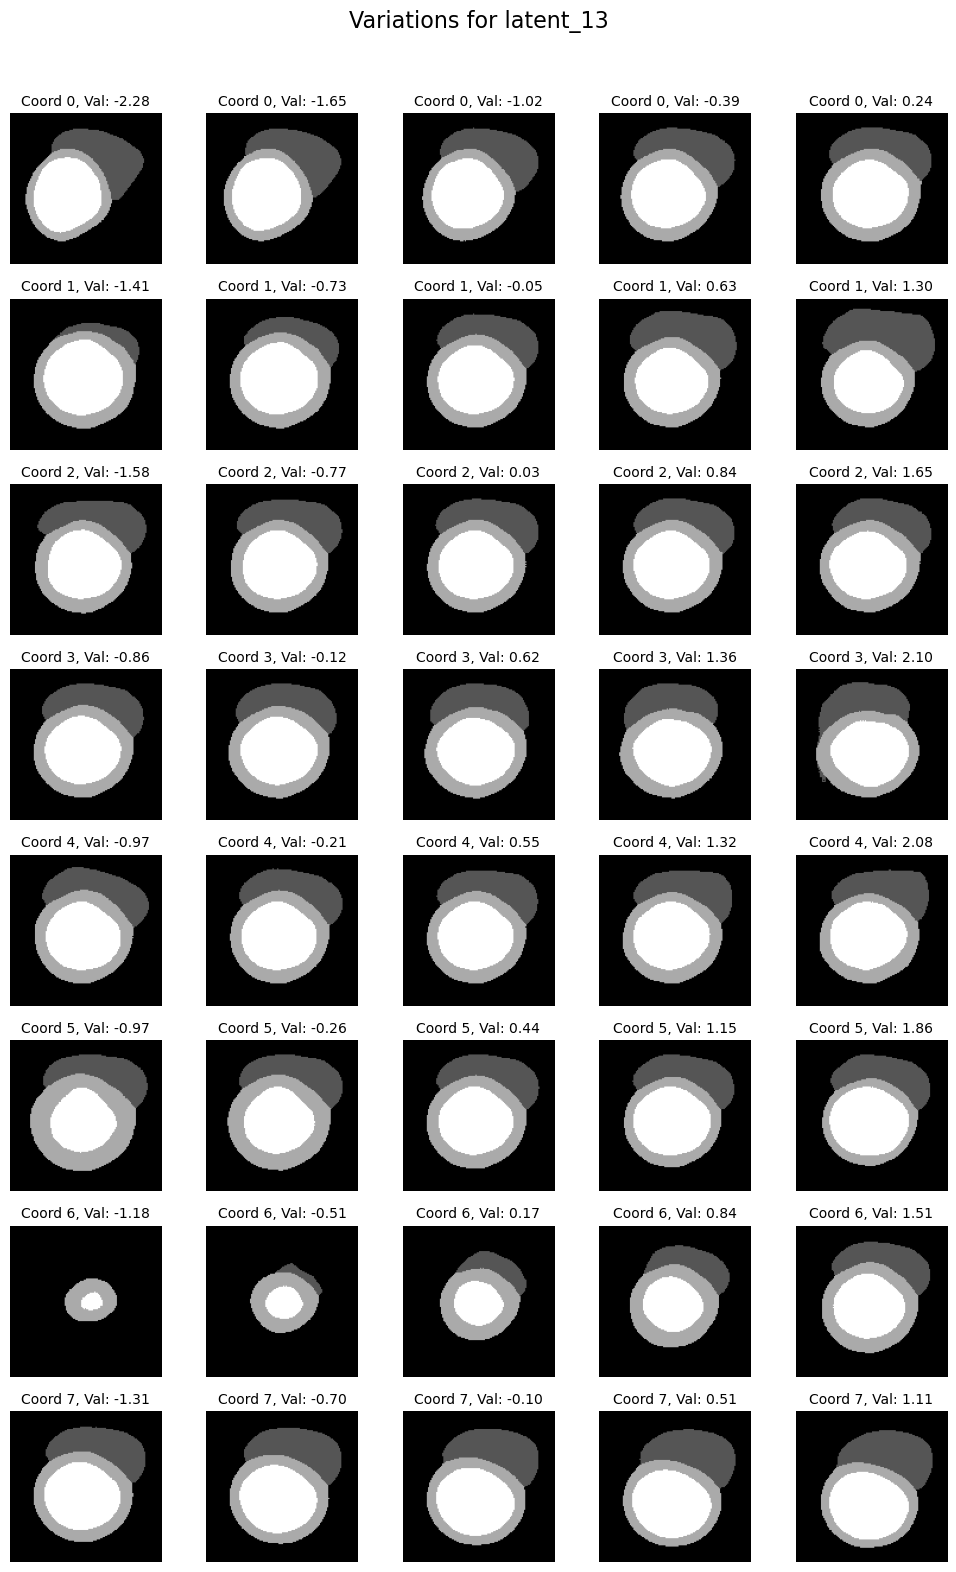

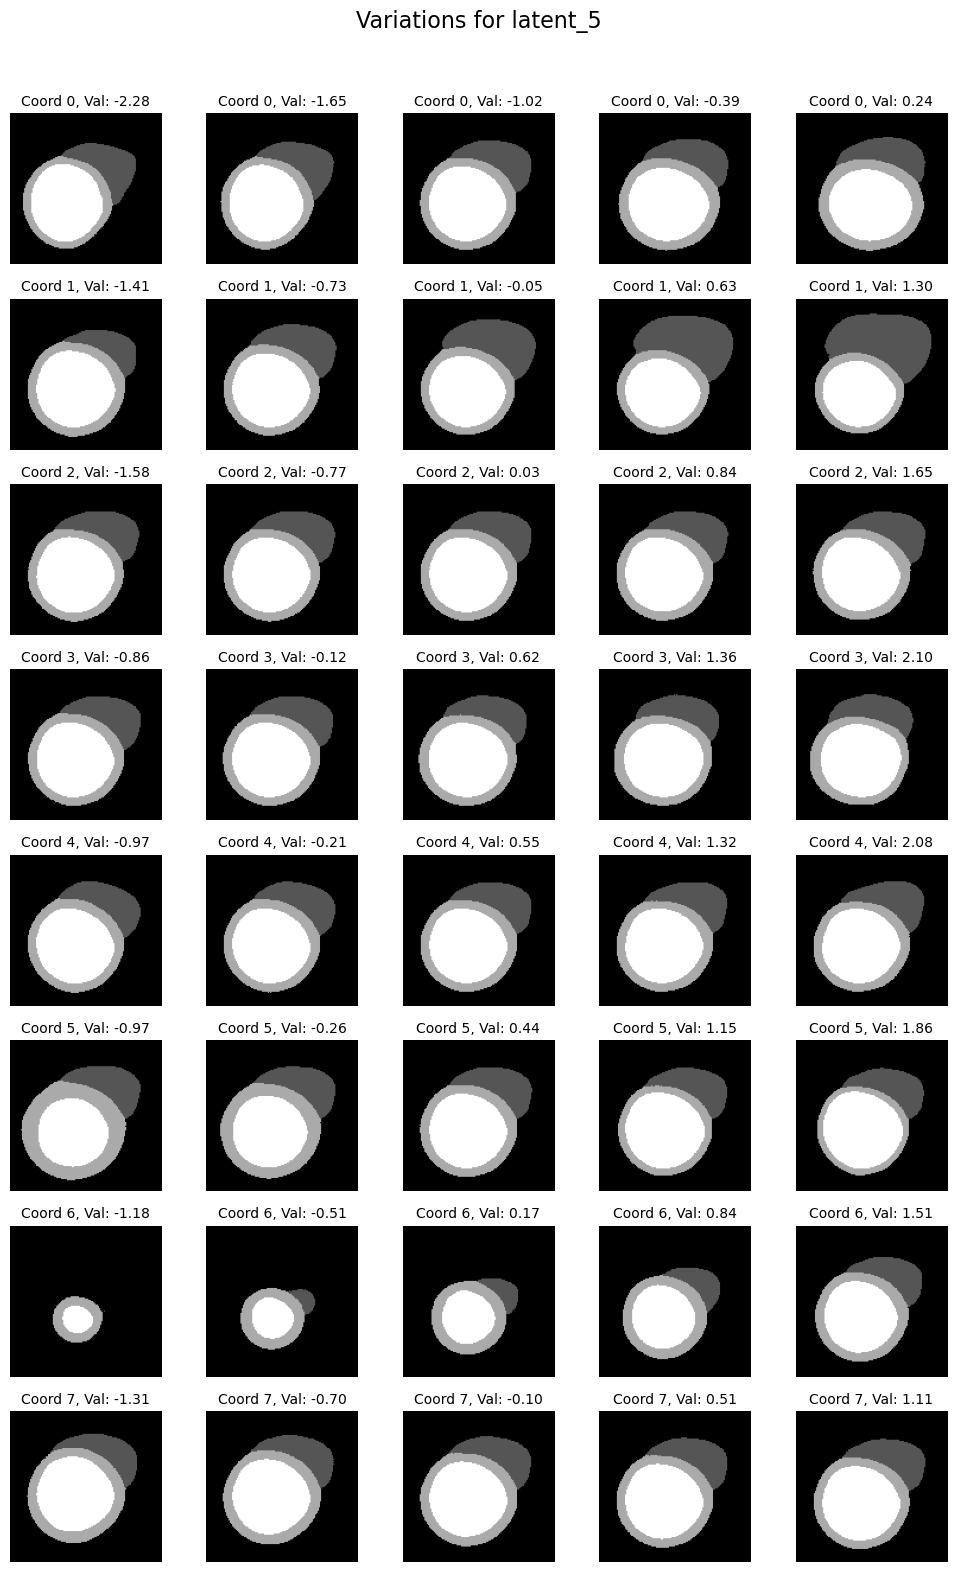

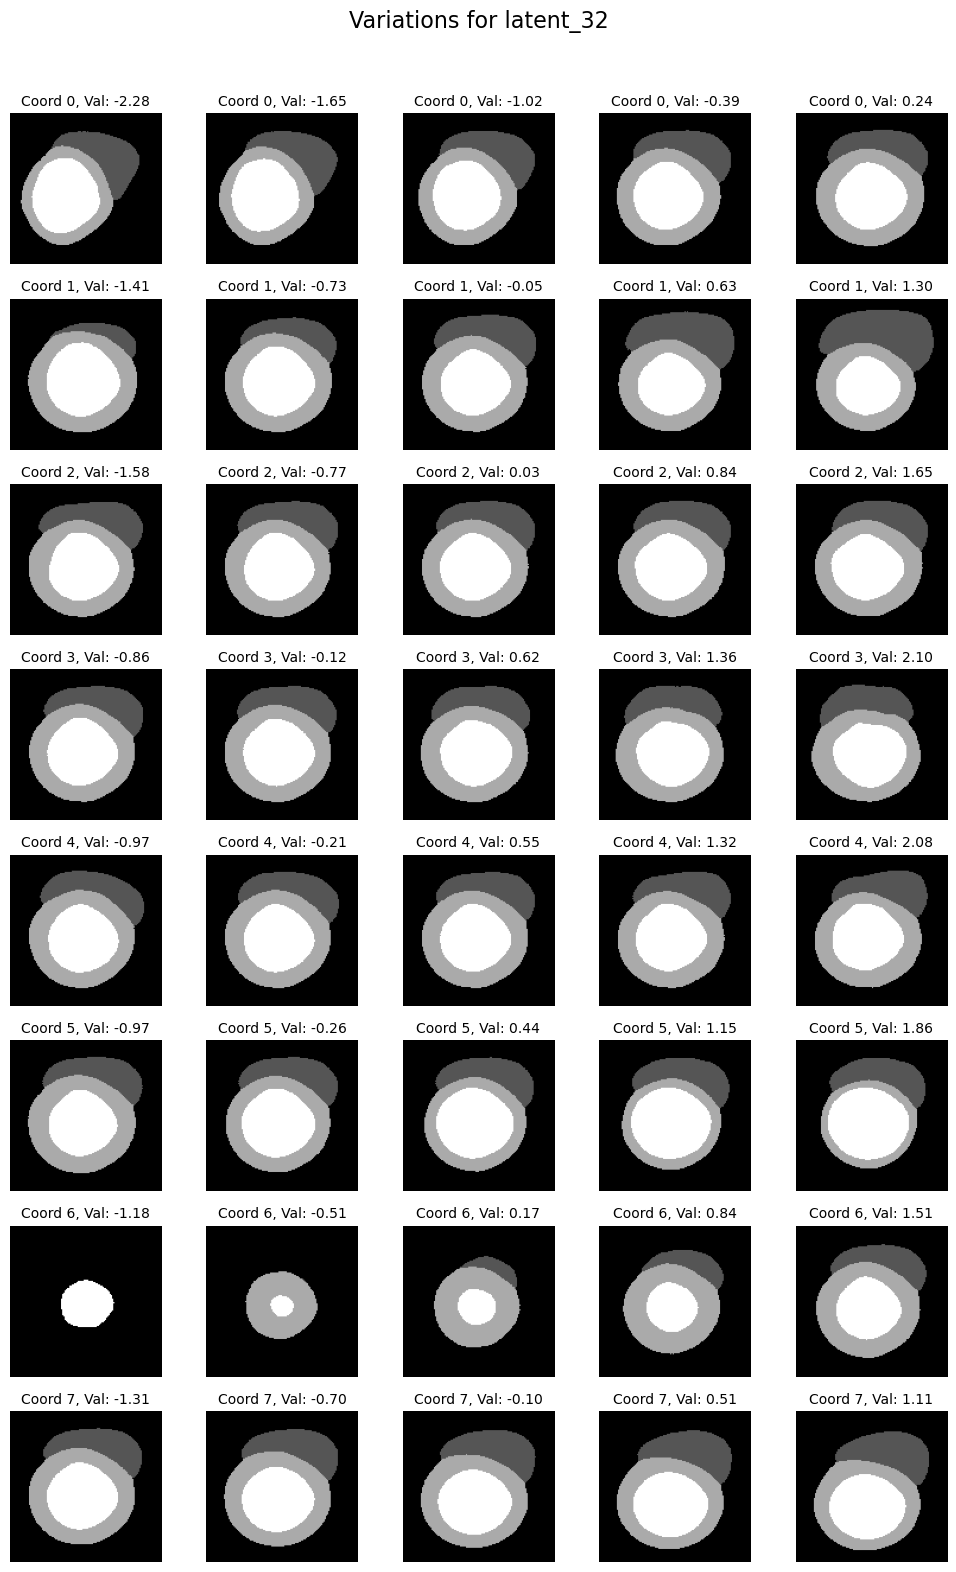

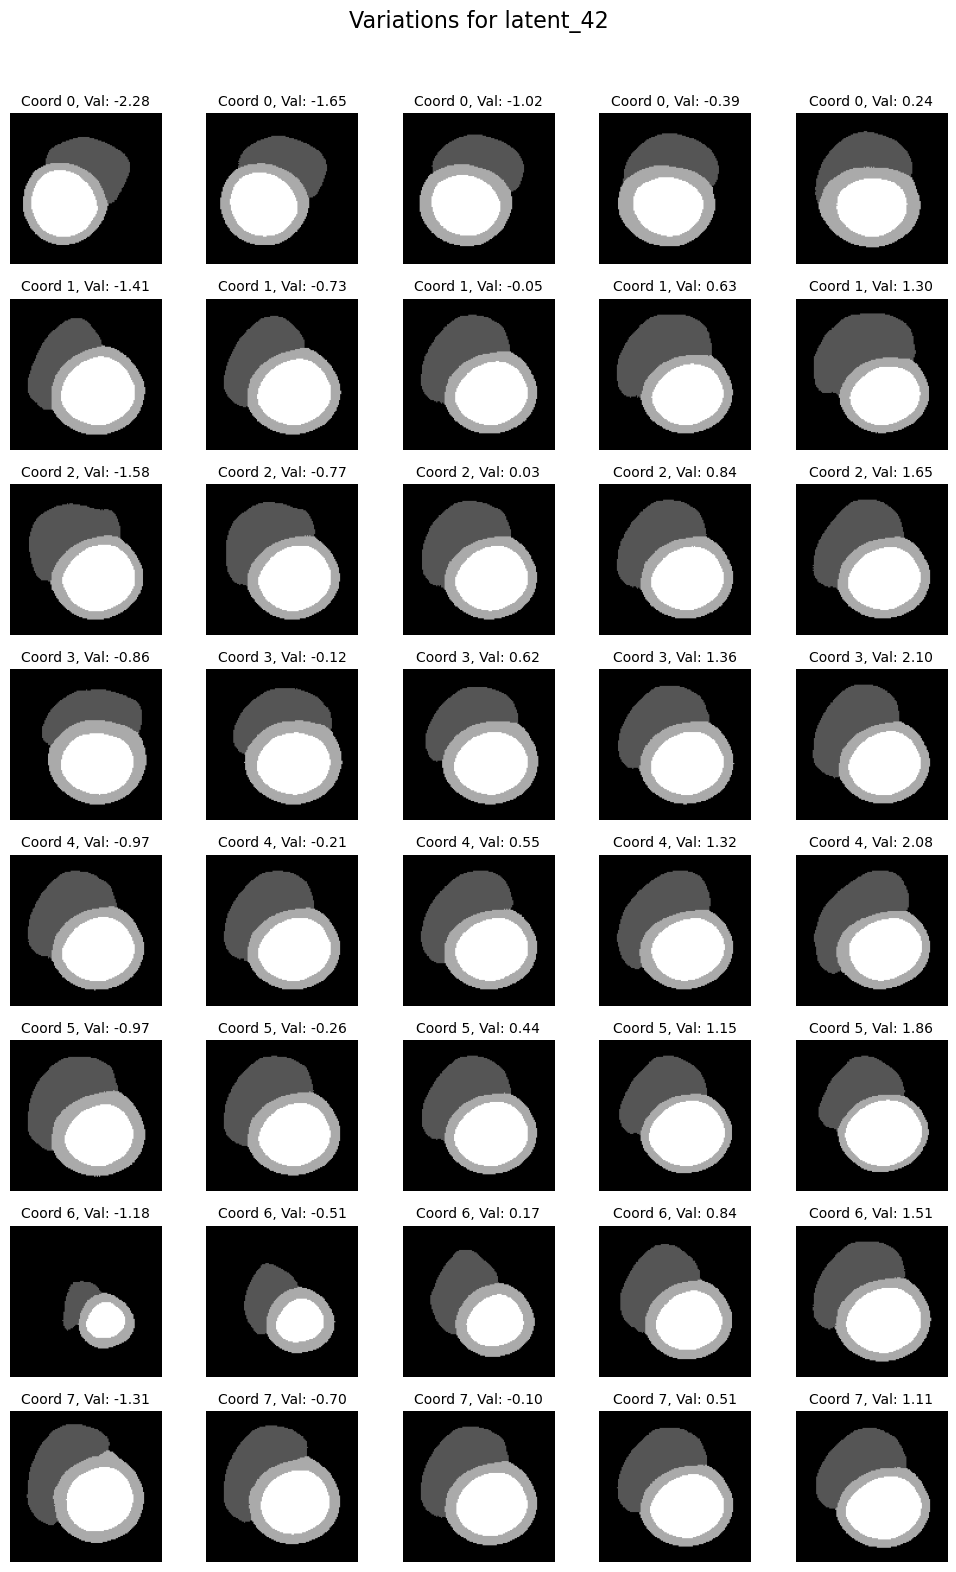

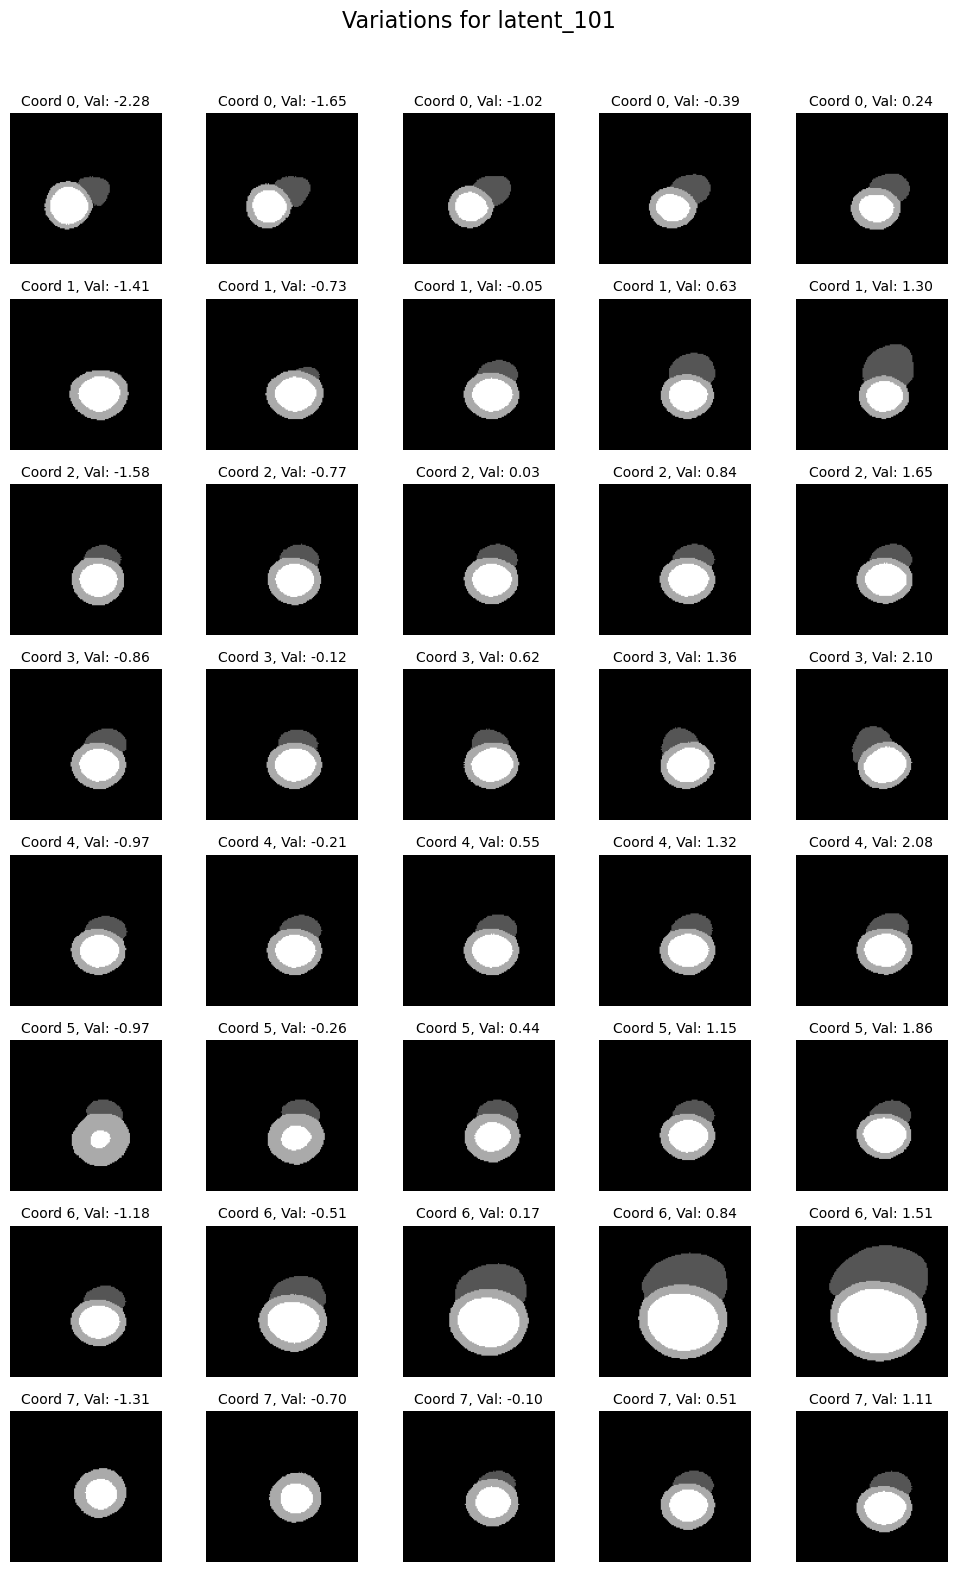

In [74]:
latent_13 = vae_model.encoder(heart_dataset[13].unsqueeze(0).to(device))[0].squeeze(0)
latent_5 = vae_model.encoder(heart_dataset[5].unsqueeze(0).to(device))[0].squeeze(0)
latent_32 = vae_model.encoder(heart_dataset[32].unsqueeze(0).to(device))[0].squeeze(0)
latent_42 = vae_model.encoder(heart_dataset[42].unsqueeze(0).to(device))[0].squeeze(0)
latent_101 = vae_model.encoder(heart_dataset[101].unsqueeze(0).to(device))[0].squeeze(0)

latents = [latent_13, latent_5, latent_32, latent_42, latent_101]

# Ensure latents is a list of numpy arrays
latents = [latent.cpu().detach().numpy() for latent in latents]
latent_names = ["latent_13", "latent_5", "latent_32", "latent_42", "latent_101"]

# Convert minima and maxima lists to numpy arrays
minima = np.array(minima)
maxima = np.array(maxima)

# Number of steps to vary each coordinate
num_steps = 5

# Function to visualize the variations
def visualize_variations(latent_vectors, minima, maxima, num_steps=5):
    num_latents = len(latent_vectors)
    latent_dim = latent_vectors[0].shape[0]

    for latent_idx, (latent, name) in enumerate(zip(latent_vectors, latent_names)):
        fig, axes = plt.subplots(latent_dim, num_steps, figsize=(10, 2 * latent_dim))

        for coord in range(latent_dim):
            # Generate values to test for the current coordinate
            values = np.linspace(minima[coord], maxima[coord], num_steps)
            
            for step_idx, value in enumerate(values):
                # Copy the latent vector and set the current coordinate to the new value
                varied_latent = latent.copy()
                varied_latent[coord] = value

                # Decode the latent vector back to an image
                with torch.no_grad():
                    varied_latent_tensor = torch.tensor(varied_latent, dtype=torch.float32).unsqueeze(0).to(device)
                    reconstructed_image = vae_model.decode(varied_latent_tensor).cpu()
                
                # Post-process the reconstructed image for visualization
                img = torch.argmax(reconstructed_image.squeeze(), dim=0)
                img = img.numpy()
                
                # Plot the image
                ax = axes[coord, step_idx]
                ax.imshow(img, cmap='gray')
                ax.axis('off')
                
                # Add title to each subplot indicating the coordinate and value
                ax.set_title(f'Coord {coord}, Val: {value:.2f}', fontsize=10)

        # Add a super title for the entire figure
        plt.suptitle(f'Variations for {name}', fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

# Visualize variations
visualize_variations(latents, minima, maxima, num_steps)


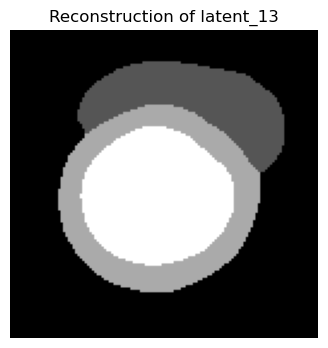

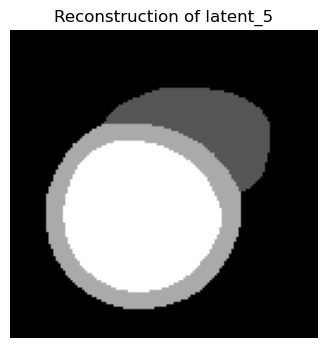

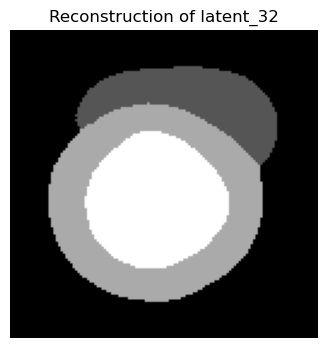

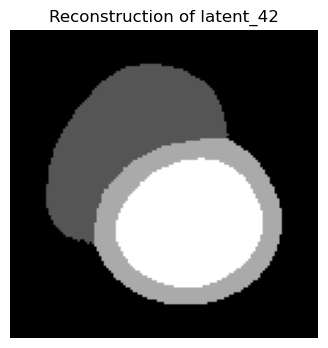

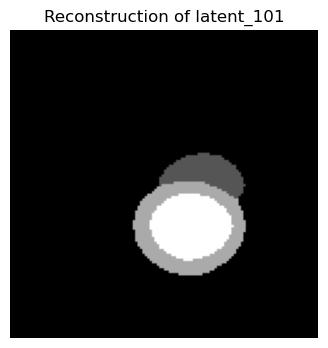

In [75]:
latents = [latent_13, latent_5, latent_32, latent_42, latent_101]

# Function to visualize the original reconstructions
def visualize_original_reconstructions(latent_vectors, latent_names):
    num_latents = len(latent_vectors)

    for latent_idx, (latent, name) in enumerate(zip(latent_vectors, latent_names)):
        fig, ax = plt.subplots(figsize=(4, 4))
        
        # Decode the latent vector to an image
        with torch.no_grad():
            latent_tensor = latent.unsqueeze(0)  # Add batch dimension
            reconstructed_image = vae_model.decoder(latent_tensor).cpu()
        
        # Post-process the reconstructed image for visualization
        img = torch.argmax(reconstructed_image.squeeze(), dim=0).numpy()
        
        # Plot the image
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        
        # Add title to the subplot indicating the name of the latent vector
        ax.set_title(f'Reconstruction of {name}', fontsize=12)

        plt.show()

# Visualize the original reconstructions
visualize_original_reconstructions(latents, latent_names)